In [1]:
#@title
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Séries Temporais (Time Series)

Notebook de apoio para a **Aula 002: Time Series (Séries Temporais) - Parte 2**

## Técnicas de *Forecasting* para Séries Temporais

O universo das Séries Temporais (TS) é gigante e complexo. Existem muitos métodos e maneiras de se realizar previsões em cima de bases históricas. Não é minha intenção apresentar extensivamente todas elas, mas sim fomentar a sua vontade por meio de conhecimentos basilares das *Time Series*.

A primeira coisa que vai ter que estar na sua cabeça é que quanto maior o seu horizonte de previsão, maior a incerteza associada a ele.

Quanto mais no futuro você tentar ver algo, menor será sua capacidade de inferir algo. Bem-vindo ao mundo real.

Para ajudar nessa tarefa, existem desde técnicas simples (qual será o valor da sua conta de celular no próximo mês) e metodologias altamente complexas e com conceitos estatísticos mais pesados (qual o risco de um tornado atingir aquela cidade).

Vamos dar uma olhada nos principais modelos básicos. Usaremos novamente a base de dados da produção de energia elétrica da última aula.

In [2]:
# importar pacotes e setar configurações de plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

sns.set_style()

%config InlineBackend.figure_format = 'svg'

In [3]:
# url do dataset
dataset_path = "https://raw.githubusercontent.com/carlosfab/escola-data-science/master/datasets/electricity_consumption/Electric_Production.csv"

# importar o csv para um dataframe
df = pd.read_csv(dataset_path)
df.DATE = pd.to_datetime(df.DATE, format="%m-%d-%Y")
df.set_index('DATE', inplace=True)

# ver as 5 primeiras entradas
df.head()

,Value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


### 1. Naive Approach

No "Modelo Ingênuo", a previsão de $P_{T+1}$ é apenas uma mera observação do período imediatamente anterior ($P_T$). Pense, qual seria o melhor chute para você dizer quanto viria a conta de celular no próximo mês?!

<br>
<center>
<img src="https://miro.medium.com/max/974/1*aVBE9ixa9HEV4Zd3keZE4A.png" width="400px">
</center>

Partir da premissa que "o futuro repetirá o passado", mesmo que parece algo ingênuo, serve como um *benchmark*, um *baseline* inicial. E por que isso?

Imagine que você construa um modelo com todas as técnicas mais avançadas, treina redes neurais profundas em cima de GPUs da AWS por dias... para descobrir que ele foi pior que um modelo Naive?

In [4]:
# dividir entre treino e validação
train = df[df.index <= '2012-8-1']
valid = df[df.index > '2012-8-1']

# criar um dataframe para armazenar as previsões
y_hat = valid.copy()

Exclusivamente por causa da didática, vou dividir o conjunto de dados em dois.

Vou utilizar períodos amplos para que a aplicação dos métodos seja perceptível visualmente.

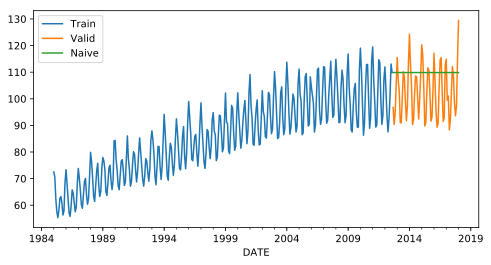

In [5]:
# copiar o último valor do dataset train e atribuir à h_hat['naive']
y_hat['naive'] = train.iloc[-1].values[0]

# plotar train e valid
fig, ax = plt.subplots(figsize=(8,4))
train.plot(ax=ax)
valid.plot(ax=ax)
y_hat['naive'].plot(ax=ax)
ax.legend(['Train', 'Valid', 'Naive'])
plt.show()

In [11]:
# Calcular o erro da previsão RMSE
print("Erro do Método Naive Method:")
mean_squared_error(y_hat.Value, y_hat.naive, squared=True)

Erro do Método Naive Method:


TypeError: mean_squared_error() got an unexpected keyword argument 'squared'

In [ ]:
mean_squared_error()

### 2. Média Móvel

Se no Método *Naive* nós consideramos apenas o último valor disponível, as médias móveis permitem utilizarmos uma janela de intervalo.

Se você investe na Bolsa como trader, provavelmente já usou médias móveis com valores de 7, 14, 21 dias. 

Médias móveis são excelentes para suavizar curvas (e diminuir a dispersão/ruído) ou mesmo para criar novas variáveis (*feature engineering*).

Voltando ao exemplo da sua conta de celular, usando médias móveis nós poderíamos usar (por exemplo) as 7 últimas faturas e prever as demais.

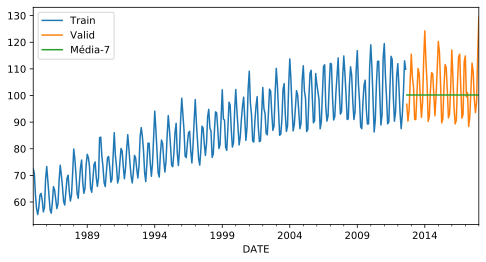

In [7]:
# calcular a média dos últimos 7 valores disponíveis
y_hat['m7'] = train.Value.rolling(7).mean().iloc[-1]

# plotar train e valid
fig, ax = plt.subplots(figsize=(8,4))
train.plot(ax=ax)
valid.plot(ax=ax)
y_hat['m7'].plot(ax=ax)
ax.legend(['Train', 'Valid', 'Média-7'])
plt.show()

In [8]:
# Calcular o erro da previsão RMSE
print("Erro da Média de 7 dias:")
mean_squared_error(y_hat.Value, y_hat.m7, squared=True)

Erro da Média de 7 dias:


101.2125496049239

### 3. Holt's Linear Trend Model

Qual o problema das técnicas acima? Elas não permitem que trabalhemos com tendências (apenas o nível das séries).

Já o *Holt's Linear Trend Model* leva em consideração tanto o nível quanto a tendência, e tende a obter melhores resultados que as técnicas mencionadas anteriormente.

Vamos separar os componentes da Série Temporal

In [0]:
# importar pacotes necessários
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import Holt

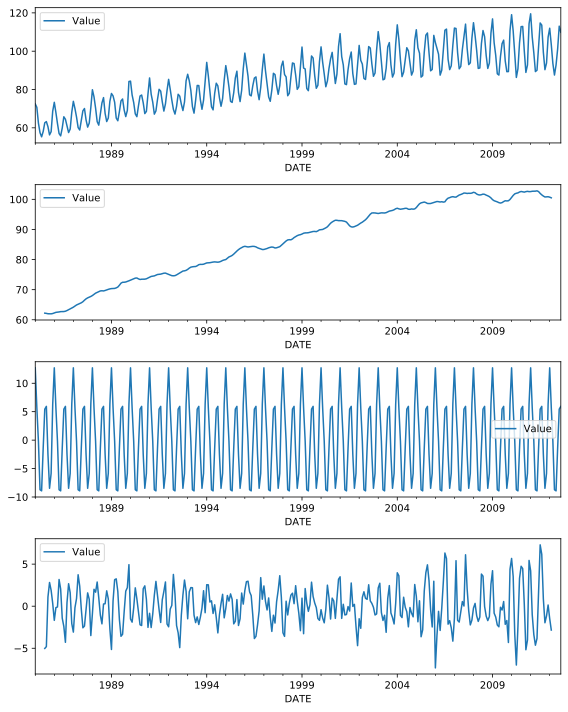

In [10]:
# salvar os componentes da *time series* na variável results
result = seasonal_decompose(train)

# plotar componentes
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(8,10))
result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)
plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


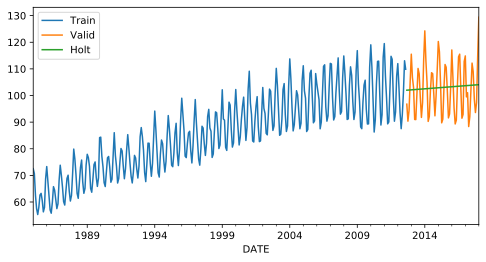

In [11]:
# salvar os valores para o dataset valid usando Holt's
y_hat['holt'] = Holt(train.Value).fit(smoothing_level=0.1,
                                      smoothing_slope=0.1).forecast(len(valid))

# plotar train e valid
fig, ax = plt.subplots(figsize=(8,4))
train.plot(ax=ax)
valid.plot(ax=ax)
y_hat['holt'].plot(ax=ax)
ax.legend(['Train', 'Valid', 'Holt'])
plt.show()

In [12]:
# Calcular o erro
print("Erro do Holt's Linear Trend Model:")
mean_squared_error(valid.Value, y_hat.holt, squared=True)

Erro do Holt's Linear Trend Model:


93.79197449495115

## Séries Estacionárias

Antes de se pensar em fazer previsões e modelagens preditivas, você tem que ter um conceito bem fixado: séries estacionárias.

Uma TS é chamada de estacionária caso possua suas propriedades estatísticas sejam constantes em relação ao tempo. Por exemplo, são critérios básicos:

1. Média constante em relação ao tempo
2. Variância constante em relação ao tempo
3. Covariância entre os termos $T_i$ e $T_{i+m}$ é constante em relação ao tempo.

E por que isso? Porque a grande maioria dos métodos estatísticos assume essa premissa.

**E caso minha TS não seja estacionária?**

Bom, nesse caso você terá que aplicar transformações matemáticas para que ela se torne estacionária.

**E o exemplo de produção de energia elétrica? É estacionário ou não?**

Apenas olhando o gráfico original + os componentes separados, já conseguimos notar que existe no mínimo uma tendência de crescimento. 

No entanto, "olhômetro" não é um método muito científico. Como devemos proceder?

Devemos utilizar testes estatísticos para confirmar se uma série é estacionário ou não. Vamos utilizar aqui o ***ADF (Augmented Dickey-Fuller) Test***, ou Teste de Dickey-Fuller Aumentado.

### Teste de Dickey-Fuller

Resumidamente, o ADF tem a capacidade de nos dizer se uma TS é estacionária ou não. 

Sem entrarmos (ainda) em detalhes, vamos rodar o teste estatístico e ver o que ele nos fala.


In [13]:
# importar o teste ADF
from statsmodels.tsa.stattools import adfuller

# importar os dados como sendo coluna única
df_est = pd.read_csv(dataset_path, index_col=0, squeeze=True)

# extrair apenas os valores
X = df_est.values

# aplicar ADF e imprimir o resultado
result = adfuller(X)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result[0]))
print('Valor-p: {:.4f}'.format(result[1]))
print('Valores Críticos:')
for key, value in result[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Dickey-Fuller Aumentado
Teste Estatístico: -2.2570
Valor-p: 0.1862
Valores Críticos:
	1%: -3.4476
	5%: -2.8692
	10%: -2.5708


Vamos entender um pouco sobre o que está sendo verificado.

* A Hipótese Nula ($H_0$) do teste é que a TS não é estacionária. Ou seja, possui algum tipo de dependência em relação ao tempo.
* A Hipótese Alternativa ($H_1$) rejeita a hipótese nula, ou seja, que a TS é estacionária.

Interpretamos o resultado do teste usando o *valor-p* com um *threshold* que traga indícios suficientes para rejeitarmos a hipótese nula. Caso o valor do teste fique acima desse *threshold*, falharemos em rejeitar a hipótese nula e manteremos a premissa de que ela não é estacionária.

Os valores do *threshold* que irei usar são:

* $\text{Valor-p } \leq 0.05$: Rejeitamos $H_0$ e a TS é estacionária; e
* $\text{Valor-p } > 0.05$: Falhamos em rejeitar $H_0$ e a TS é não-estacionária.
